In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import interpolate, signal

from tqdm.notebook import tqdm, trange
from tqdm.keras import TqdmCallback

import pathlib, sys, os
from os import *

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_recall_curve, classification_report, confusion_matrix,accuracy_score,
                             precision_score, recall_score, f1_score,roc_auc_score, auc)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
plt.style.use('classic')
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['axes.grid'] = True

# חיבור הנתונים הישנים והחדשים 


In [ ]:
data= pd.read_csv('data_uri.csv')
data=data[data['Axis']!='t']
data.reset_index(drop=True, inplace=True)
full_data_old=data.copy()

# for new data:
data_new=pd.read_csv('data_new.csv')
data_new=data_new[data_new['Axis']!='t']
data_new.reset_index(drop=True, inplace=True)
data_new_full= data_new.copy()

new_features = ['vig', 'mod', 'walk', 'IPAQ_activity',
       'IPAQ_sitting', 'BriefBESTest', 'height','weight', 'bmi']
# Use list comprehension to select columns not in exclude list
columns = [col for col in data_new.columns if col not in new_features]
data_new_old_format = data_new[columns]

data= pd.concat([data,data_new_old_format])
data.reset_index(drop=True, inplace=True)


## ללא חיבור

In [199]:
# for new data:
data=pd.read_csv('data_uri.csv')
data=data[data['Axis']!='t']
data.reset_index(drop=True, inplace=True)
data_new= data.copy()


In [200]:
data

,Subject,Age,Gender,Axis,0,1,2,3,4,5,...,kurtosis,skewness,FOM,SOM,Norm_FOM_L1,Norm_FOM_L2,Norm_SOM_L1,Norm_SOM_L2,Spectral_Energy,Spectral_Entropy
0,1,72,2,x,1.5351,1.823118,1.510791,1.778278,1.825153,1.678019,...,1.799400,0.139896,-4.049130,-3.831639,937.342639,35.652549,3.831639,3.831639,1.525325e+06,6.645762
1,1,72,2,y,-0.0244,-0.674992,-0.762504,0.165144,0.428236,0.384300,...,-0.938816,0.356459,-3.470323,-3.469671,1997.783374,68.892046,3.469671,3.469671,5.695337e+06,4.232504
2,1,72,2,z,0.1078,-0.007074,0.450877,0.695231,0.408127,0.062126,...,2.741493,1.351603,-4.578469,-4.317916,1613.420701,66.253124,4.317916,4.317916,5.267372e+06,6.221048
3,4,25,1,x,0.4565,0.970377,0.958877,0.918373,0.859173,0.867728,...,0.603487,0.083930,-2.992759,-2.973056,944.474545,35.722433,2.973056,2.973056,1.531311e+06,7.143985
4,4,25,1,y,0.5147,1.111909,1.098434,0.999698,0.782577,0.530835,...,0.827162,0.777271,-3.856895,-3.830053,1493.821069,57.012236,3.830053,3.830053,3.900474e+06,5.498233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,183,70,1,y,0.0815,0.085675,0.001658,-0.068394,-0.102508,-0.110469,...,-0.631236,0.239281,-3.286617,-3.257619,1450.882508,53.146660,3.257619,3.257619,3.389481e+06,3.592353
491,183,70,1,z,-0.5184,-0.131851,0.062824,0.196576,0.256448,0.230278,...,1.903766,-1.327306,-3.213378,-3.184666,678.420418,28.699340,3.184666,3.184666,9.883825e+05,6.553911
492,184,39,2,x,-0.4554,-0.374100,-0.267811,-0.178907,-0.009195,0.081383,...,1.840942,0.625085,-2.399061,-2.392951,677.260365,27.647246,2.392951,2.392951,9.172443e+05,6.743459
493,184,39,2,y,0.2686,-0.069465,-0.204796,-0.226551,-0.194341,-0.116126,...,0.071880,0.297864,-2.273581,-2.270524,870.974176,33.571119,2.270524,2.270524,1.352424e+06,4.409634


In [190]:
full_data=data.copy()
data=data.iloc[:,:1204]
n_seconds = 12
# data=data.iloc[:,:804]
# n_seconds = 8
newfreq = 100
new_columns = {col: int(col) if col.isdigit() else col for col in data.columns}
data.rename(columns=new_columns, inplace=True)

  0%|          | 0/165 [00:00<?, ?it/s]

(165, 1200, 49, 3)
True label: 48.5%


C:\Users\USER\AppData\Local\Temp\ipykernel_25848\2777573171.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  static_features_data['Axis'] = static_features_data['Axis'].replace(axis_mapping)


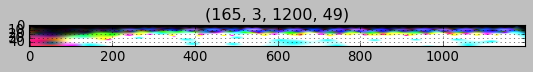

In [191]:
def moving_average(x, w = 20):
    return np.pad(np.array([np.mean(x[i:i+w]) for i in range(x.shape[0] - w)], dtype = np.float64),
                  (0,w), mode = 'constant')


# we generate numpy arrays (train, validation and test) for both X and y
n = int(n_seconds * newfreq)

ageThreshold = 45
y = data.loc[np.arange(0, len(data), 3), 'Age'].values
y = (y > ageThreshold).astype(int).reshape(-1,1)

X = data[np.arange(n)].values.reshape(-1, 3, n)
X = np.transpose(X, [0,2,1])

Xt = np.zeros((X.shape[0], 3, X.shape[1], 49))

# filtering using low-pass butterworth

for x in trange(X.shape[0]):
    for i in range(3):
        X[x][:,i] = signal.detrend(X[x][:,i])
        X[x][:,i] = moving_average(X[x][:,i])
        Xt[x][i] = np.abs(signal.cwt(X[x][:,i], wavelet = signal.morlet2, widths = np.arange(1, 50)).T)

X = Xt


plt.imshow(X[0].T)
plt.title(str(X.shape))

X = X.transpose(0,2,3,1)
print(X.shape)

# prepare the data set
batch_size = 32

# defining classes as categorical
print(f"True label: {y.mean() * 100:.1f}%")


static_features_data= full_data.iloc[:,np.r_[2:4, 1205:full_data.shape[1]]]
static_features_dataaxis_mapping = {'x': 1, 'y': 2, 'z': 3}
static_features_data['Axis'] = static_features_data['Axis'].replace(axis_mapping)
static_features_array = static_features_data.values

# Determine the number of features
num_features = static_features_array.shape[1]

# Calculate the number of subjects based on the number of rows
num_rows = static_features_array.shape[0]
num_subjects = num_rows // 3

# Reshape the data
static_features = static_features_array.reshape(num_subjects, 3, num_features)

# building the model

In [192]:
Xt = np.transpose(Xt, (0, 2, 3, 1))
def init_model():
    cwt_inputs = keras.Input(shape = X.shape[1:], name='cwt_input')    
    x = cwt_inputs[:,:,0]
    y = cwt_inputs[:,:,1]
    z = cwt_inputs[:,:,2]
    
    x = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(x)
    x = layers.MaxPool1D(pool_size = 3)(x)        
    x = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(x)
    x = layers.MaxPool1D(pool_size = 3)(x)        
    x = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(x)
    x = layers.MaxPool1D(pool_size = 3)(x)        
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(x)        
    x = layers.Dense(4, activation = "relu")(x)
    
    y = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(y)
    y = layers.MaxPool1D(pool_size = 3)(y) 
    y = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(y)
    y = layers.MaxPool1D(pool_size = 3)(y) 
    y = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(y)
    y = layers.MaxPool1D(pool_size = 3)(y) 
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(0.5)(y)
    y = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(y)
    y = layers.Dense(4, activation = "relu")(y)
    
    z = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(z)
    z = layers.MaxPool1D(pool_size = 3)(z) 
    z = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(z)
    z = layers.MaxPool1D(pool_size = 3)(z) 
    z = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(z)
    z = layers.MaxPool1D(pool_size = 3)(z) 
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.5)(z)
    z = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(z)
    z = layers.Dense(4, activation = "relu")(z)
    cwt = layers.Flatten()(tf.concat([x,y,z], axis = 1))

    # static_input = keras.Input(shape=static_features.shape[1:], name='static_input')
    # static_processed = layers.Flatten()(static_input)
    # static_processed = layers.Dense(64, activation="relu")(static_processed)
    # static_processed = layers.Dropout(0.5)(static_processed)
    # # Flatten the static features
    # static_processed = layers.Flatten()(static_processed)



    static_input = keras.Input(shape=static_features.shape[1:], name='static_input')
    static_processed = layers.Dense(128, activation="relu")(static_input)  # Increase the capacity
    static_processed = layers.Dropout(0.3)(static_processed)  # Adjust dropout rate
    static_processed = layers.Dense(64, activation="relu")(static_processed)
    static_processed = layers.Dropout(0.3)(static_processed)  # Another dropout layer for more regularization
    static_processed = layers.Flatten()(static_processed)  # Flatten to prepare for concatenation

    combined = layers.concatenate([cwt, static_processed])
    # Fully connected layers after concatenation
    outputs = layers.Dense(64, activation='relu')(combined)
    outputs = layers.Dense(1, activation='sigmoid')(outputs)
    
    
    model = keras.Model(inputs = [cwt_inputs,static_input], outputs = outputs)
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=100,
        decay_rate=0.9)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(loss="binary_crossentropy",
                  optimizer = optimizer,
                  metrics = [tf.keras.metrics.AUC(curve = 'ROC')]

                  )
    
    return model


model = init_model()
model.summary()

Model: "model_98"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 cwt_input (InputLayer)      [(None, 1200, 49, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_2  (None, 1200, 3)              0         ['cwt_input[0][0]']           
 94 (SlicingOpLambda)                                                                             
                                                                                                  
 tf.__operators__.getitem_2  (None, 1200, 3)              0         ['cwt_input[0][0]']           
 95 (SlicingOpLambda)                                                                             
                                                                                           

In [193]:
# Assuming Xt is reshaped correctly and static_features is prepared
# X = X.transpose(0,2,3,1)
epochs = 700
batch_size = 32
k = 5  # Number of folds

k_fold = KFold(n_splits=k, shuffle=True)
results = []

for fold, (train_idx, test_idx) in enumerate(k_fold.split(Xt)): 
    print(f"Training on fold {fold+1}...")

    train_dataset = tf.data.Dataset.from_tensor_slices(
        ({'cwt_input': Xt[train_idx], 'static_input': static_features[train_idx]}, y[train_idx])
    ).shuffle(buffer_size=1024).batch(batch_size)

    test_dataset = tf.data.Dataset.from_tensor_slices(
        ({'cwt_input': Xt[test_idx], 'static_input': static_features[test_idx]}, y[test_idx])
    ).batch(batch_size)

    model = init_model()

    checkpoint_path = f"best_model_fold_{fold+1}.h5"

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss')
    ]


    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=test_dataset,
        callbacks=callbacks,
        verbose=0
    )

    # Evaluation part remains the same
    predictions = (model.predict(test_dataset) > 0.5).astype(int)
    y_true = np.array([y for _, y in test_dataset.unbatch()])
    accuracy= accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions)
    recall = recall_score(y_true, predictions)
    roc_auc = roc_auc_score(y_true, predictions)

    print(f"Fold {fold+1}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, ROC-AUC={roc_auc:.4f}")
    results.append((accuracy,precision, recall, roc_auc))

avg_accuracy = np.mean([result[0] for result in results])
avg_precision = np.mean([result[1] for result in results])
avg_recall = np.mean([result[2] for result in results])
avg_roc_auc = np.mean([result[3] for result in results])
print(f"Average Accuracy: {avg_precision:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average ROC-AUC: {avg_roc_auc:.4f}")


Training on fold 1...


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 8ms/step
Fold 1: Accuracy=0.6364, Precision=0.6000, Recall=0.4286, ROC-AUC=0.6090
Training on fold 2...


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 6ms/step
Fold 2: Accuracy=0.6061, Precision=0.7778, Recall=0.3889, ROC-AUC=0.6278
Training on fold 3...


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 2ms/step
Fold 3: Accuracy=0.6061, Precision=0.6364, Recall=0.7368, ROC-AUC=0.5827
Training on fold 4...


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 8ms/step
Fold 4: Accuracy=0.5152, Precision=0.5000, Recall=1.0000, ROC-AUC=0.5294
Training on fold 5...


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 4ms/step
Fold 5: Accuracy=0.6364, Precision=0.6667, Recall=0.1538, ROC-AUC=0.5519
Average Accuracy: 0.6362
Average Precision: 0.6362
Average Recall: 0.5416
Average ROC-AUC: 0.5802


# Functions

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def fetch(subjects, df, freq=128, n_seconds=3, train=False):
    """
    A function to read subjects accelerometer data.

    params:
        subjects : a list of subjects folders
        freq     : the sampling frequency all signals will be converted to
        n_seconds: number of seconds to fetch from each signal
        train    : if true, fetches two n_seconds signals from each recording, as data augmentation. default: False

    """

    output = pd.DataFrame()  # output dataframe
    num_index = 0  # Initialize num_index outside the loop
    # for each subject, try to read accelerometer data
    for s in tqdm(subjects):
        try:
            data = pd.read_csv(s + '.csv')
            data.columns = ['time', 'x', 'y', 'z', 't']
        except:
            print(s, ':\t', sys.exc_info()[0])
            continue

        # remove very short recordings
        if data['time'].max() < 12:
            print(f'Too short dataset {s}: {data["time"].max()}')
            continue

        # data cleaning: if accelerometer is turned off, remove following data.
        off_phase = np.where(np.diff(data.time) > 1)[0]
        if off_phase.shape[0] > 0:
            data = data.loc[:off_phase[0]]

        # calculate sampling frequency for each subject
        fs = data.time.idxmax() / data.time.max()

        data.set_index('time', inplace=True)

        # take n_seconds measurements. we take n_seconds around the first quarter, as the middle point is
        # often when the person turned back.
        if train:
            n_seconds *= 2
        middle = data.index.max() / 4
        start = middle - n_seconds / 2
        end = middle + n_seconds / 2
        data = data[(data.index > start) & (data.index < end)]

        # up/down sample to <freq> hz
        x = data.index
        xnew = np.linspace(min(x), max(x), freq * n_seconds)
        for c in data.columns:
            y = data[c]
            f = interpolate.interp1d(x, y, bounds_error=False, fill_value="extrapolate")
            ynew = f(xnew)
            temp = pd.DataFrame(ynew.reshape(1, -1))

            temp['Subject'] = df.iloc[num_index]['Subject']
            temp['Axis'] = c
            output = output.append(temp, ignore_index=True)

        num_index += 1  # Increment num_index for each subject

    # Merge with additional information from df
    output = output.merge(df, how='left', on='Subject')

    # Reorder columns
    output = output[['Subject', 'Age','Gender', 'vig',	'mod', 'walk',	'IPAQ_activity',	'IPAQ_sitting', 'BriefBESTest', 'height',	'weight', 'bmi', 'Axis'] + list(range(freq * n_seconds))]

    return output

# Reading subjects age data

In [ ]:
# # we get four lines per subject - representing the accelerometer's x, y,z and T components.
# display(data.head(8))

# # and we can see an example
# d = data[data['Subject'] == subjects[1]]  # Selecting data for the first subject
# d.loc[:, np.arange(data.columns[-1])].T.plot()
# plt.legend(labels=['x', 'y', 'z', 't'])
# plt.title('Final data example')
# plt.show()

In [204]:
# for new data:
data=pd.read_csv('data_new.csv')
data=data[data['Axis']!='t']
data.reset_index(drop=True, inplace=True)
data_new= data.copy()
full_data=data.copy()
# data=data.iloc[:,:813]
# n_seconds = 8
data=data.iloc[:,:1213]
n_seconds = 12

newfreq = 100
new_columns = {col: int(col) if col.isdigit() else col for col in data.columns}
data.rename(columns=new_columns, inplace=True)

In [215]:
ageThreshold = 45
y = data.loc[np.arange(0, len(data), 3), 'Age'].values
y

array([55, 45, 46, 57, 60, 57, 65, 64, 55, 49, 45, 25, 63, 23, 25, 27, 24,
       22, 21, 26, 60, 53, 62, 27, 48, 64, 63], dtype=int64)

In [214]:
ageThreshold = 45
y = data.loc[np.arange(0, len(data), 3), 'Age'].values
y = (y > ageThreshold).astype(int)
# y = (y > ageThreshold).astype(int).reshape(-1,1)
y

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1])

  0%|          | 0/27 [00:00<?, ?it/s]

(27, 1200, 49, 3)
True label: 59.3%


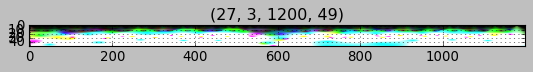

In [205]:
def moving_average(x, w = 20):
    return np.pad(np.array([np.mean(x[i:i+w]) for i in range(x.shape[0] - w)], dtype = np.float64),
                  (0,w), mode = 'constant')


# we generate numpy arrays (train, validation and test) for both X and y
n = int(n_seconds * newfreq)

ageThreshold = 45
y = data.loc[np.arange(0, len(data), 3), 'Age'].values
y = (y > ageThreshold).astype(int).reshape(-1,1)

X = data[np.arange(n)].values.reshape(-1, 3, n)
X = np.transpose(X, [0,2,1])

Xt = np.zeros((X.shape[0], 3, X.shape[1], 49))

# filtering using low-pass butterworth

for x in trange(X.shape[0]):
    for i in range(3):
        X[x][:,i] = signal.detrend(X[x][:,i])
        X[x][:,i] = moving_average(X[x][:,i])
        Xt[x][i] = np.abs(signal.cwt(X[x][:,i], wavelet = signal.morlet2, widths = np.arange(1, 50)).T)

X = Xt


plt.imshow(X[0].T)
plt.title(str(X.shape))

X = X.transpose(0,2,3,1)
print(X.shape)

# prepare the data set
batch_size = 32

# defining classes as categorical
print(f"True label: {y.mean() * 100:.1f}%")

# static_features_data= full_data.iloc[:,np.r_[2:13, 814:full_data.shape[1]]]
# static_features_data= full_data.iloc[:,np.r_[2:13, 1214:full_data.shape[1]]]
static_features_data= full_data.iloc[:,np.r_[1:3, 1214:full_data.shape[1]]]
# axis_mapping = {'x': 1, 'y': 2, 'z': 3}
# static_features_data['Axis'] = static_features_data['Axis'].replace(axis_mapping)
static_features_array = static_features_data.values

# Determine the number of features
num_features = static_features_array.shape[1]

# Calculate the number of subjects based on the number of rows
num_rows = static_features_array.shape[0]
num_subjects = num_rows // 3

# Reshape the data
static_features = static_features_array.reshape(num_subjects, 3, num_features)

In [217]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd

# Prepare the static features
# axis_mapping = {'x': 1, 'y': 2, 'z': 3}
# static_features_data['Axis'] = static_features_data['Axis'].replace(axis_mapping)
static_features_array = static_features_data.values

num_features = static_features_array.shape[1]
num_rows = static_features_array.shape[0]
num_subjects = num_rows // 3  # Assuming 3 features per subject
static_features = static_features_array.reshape(num_subjects, 3, num_features)

accuracy_results = []

for i in range(1,6):
    model = load_model(f'best_model_fold_{i}.h5')
    
    # Make predictions with the model
    predictions = model.predict([X, static_features])
    predicted_classes = (predictions > 0.5).astype(int)
    
    # Compare predictions with actual data
    data_subset = data.iloc[::3]  # Assuming 'data' is your original dataset
    comparison_df = pd.DataFrame({
        'Age': data_subset['Age'].values,
        'Predicted_Class': predicted_classes.flatten()
    })
    
    # Define a function to determine correctness
    comparison_df['is_correct'] = comparison_df.apply(lambda row: 1 if ((row['Age'] > 45) == row['Predicted_Class']) else 0, axis=1)
    accuracy = comparison_df['is_correct'].sum() / len(comparison_df)
    
    accuracy_results.append(accuracy)

# Calculate the average accuracy over all folds
average_accuracy = np.mean(accuracy_results)
print(f"Average Accuracy: {average_accuracy:.4f}")


1/1 [==============================] - 1s 1s/step
Average Accuracy: 0.4889


In [225]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd

# Prepare the static features
# Assuming static_features_data is already defined and preprocessed
static_features_array = static_features_data.values

# Determine the number of features and subjects
num_features = static_features_array.shape[1]
num_rows = static_features_array.shape[0]
num_subjects = num_rows // 3  # Assuming 3 rows per subject due to the axis mapping

# Reshape the static features for input into the model
static_features = static_features_array.reshape(num_subjects, 3, num_features)

accuracy_results = []

for i in range(1, 6):  # Adjust range if needed
    model = load_model(f'best_model_fold_{i}.h5')
    
    # Make predictions
    predictions = model.predict([X, static_features])
    predicted_classes = (predictions > 0.5).astype(int)
    
    # Compare predictions with actual data
    data_subset = data.iloc[::3]  # Assuming every third row is to be tested
    comparison_df = pd.DataFrame({
        'Age': data_subset['Age'].values,
        'Predicted_Class': predicted_classes.flatten(),
        'BriefBESTest': data_subset['BriefBESTest'].values  # Include Brief-BESTest scores
    })
    
    # Adjust correctness based on conditions described
    def adjust_correctness(row):
        if row['BriefBESTest'] <= 21 and row['Predicted_Class'] == 0:
            return 0 
        elif row['BriefBESTest'] <= 21 and row['Predicted_Class'] == 1:
            return 1 
        elif row['BriefBESTest'] > 21 and row['Predicted_Class'] == 0:
            return 1
        elif row['BriefBESTest'] > 21 and row['Predicted_Class'] == 1:
            return 0  
    
    comparison_df['is_correct'] = comparison_df.apply(adjust_correctness, axis=1)
    accuracy = comparison_df['is_correct'].sum() / len(comparison_df)
    
    accuracy_results.append(accuracy)

# Calculate the average accuracy over all models
average_accuracy = np.mean(accuracy_results)
print(f"Average Accuracy: {average_accuracy:.4f}")


1/1 [==============================] - 1s 780ms/step
Average Accuracy: 0.4889


In [226]:
comparison_df

,Age,Predicted_Class,BriefBESTest,is_correct
0,55,0,19,0
1,45,0,20,0
2,46,0,19,0
3,57,1,19,1
4,60,0,21,0
5,57,0,22,1
6,65,0,18,0
7,64,0,20,0
8,55,0,17,0
9,49,0,24,1


In [210]:
comparison_df

,Age,Predicted_Class,BriefBESTest,is_correct
0,55,0,19,1
1,45,0,20,1
2,46,0,19,1
3,57,1,19,1
4,60,0,21,1
5,57,0,22,0
6,65,0,18,1
7,64,0,20,1
8,55,0,17,1
9,49,0,24,0
